In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
plt.rcParams["figure.figsize"] = (10,5)

# Task one: is there any difference between overall scores?
Our goal is to assert any differences in overall scores between reviews. For that purpose, we are going to test whether the **mean score** of the incentivized reviews differs from that of the organic ones in a statistically meaningful way. We thus begin by loading our reviews dataset

In [36]:
data = pd.read_excel('./formatted_review_Asana.xlsx', index_col = 0) # if you get an XLRDError when loading the data use engine='openpyxl' as a kwarg
data.columns

Index(['labels', 'question1', 'question2', 'question3', 'question4', 'star'], dtype='object')

In our dataset, the scores are stored in the 'star' column. The columns 'question1' to 'question4' include the text of the reviews, which is going to be used in task 2. The 'label' column contains information about the nature of the reviews. 

There are different types, as can be seen in the cell below. However, we are going to count as organic any review with the label 'Review source: Organic' label; everything else constitutes an incentivized review.

In [4]:
data['labels'].value_counts()

Review source: G2 invite                        1075
Incentivized Review                              762
Review source: Organic                           124
Review source: G2 invite on behalf of seller     103
Review source: Seller invite                      73
Review source: G2 Gives Campaign                  13
Name: labels, dtype: int64

We are going to add a new column containing a one if the review is organic, and a zero if it is not:

In [5]:
data['label'] = 0
org = (data['labels'] == 'Review source: Organic')
data.loc[org, 'label'] = 1
data.loc[~org,'label'] = 0

In total there are 124 samples of our A group, which is going to be the organic reviews, and 2026 samples of our B group of incentivized ones.

In [6]:
data['label'].value_counts()

0    2026
1     124
Name: label, dtype: int64

In [7]:
#split the dataset
incentivized = data.loc[~org,:]
organic = data.loc[org,:]

The scores are distributed as follows:

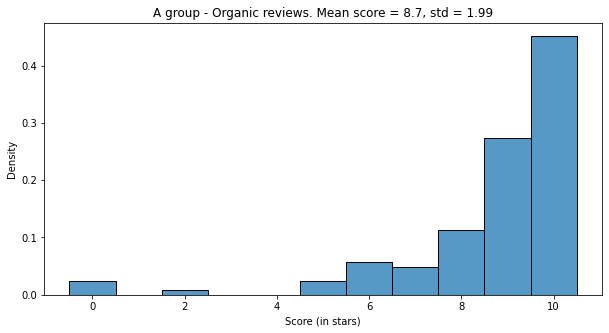

In [29]:
sns.histplot(data=organic, x="star", stat="density", discrete=True)
plt.title(
    f'A group - Organic reviews. Mean score = {round(organic["star"].mean(),2)}, std = {round(organic["star"].std(),2)}'
)
plt.xlabel("Score (in stars)")
plt.show()


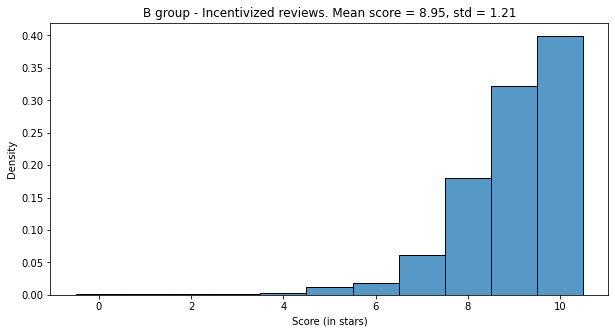

In [30]:
sns.histplot(data=data.loc[~org, :], x="star", stat="density", discrete=True)
plt.title(
    f'B group - Incentivized reviews. Mean score = {round(incentivized["star"].mean(),2)}, std = {round(incentivized["star"].std(),2)}'
)
plt.xlabel("Score (in stars)")
plt.show()

# Statistical test
We are going to perform a non-parametric permutation test, with the goal of asserting whether or not there is any significant difference between the mean score of the two groups. 

Formally speaking we will apply a Monte Carlo permutation test since it is not feasible to perform all possible permutations and calculate the exact p-value. With the Monte Carlo test we can find the p-value as $\frac{r+1}{N+1}$ where $N$ is the number of replicate samples that have been simulated and $r$ is the number of these replicates that produce a test statistic greater than or equal to that calculated for the real data. The addition of the value 1 in the numerator and denominator comes from imposing that the estimated p is unbiased. 

Under the null hypothesis, each resample has a probability of getting a test statistic at least as extreme as the one for the original sample that is equal to the permutation test p-value.

Consequently, out of N resampling simulations, the number of resamples with a test statistic at least as extreme as the one in the original sample has a binomial distribution with parameters N and p-value.  As a result, we can form a confidence interval for the p-value using standard methods for a binomial proportion confidence interval. Particulary we use Wilson score interval.

In relation to this, we are assuming in the null hypothesis that there is exchangeability in the data, and because of this we assume that all the data belong to the same population and that the fact of resampling them does not generate anything more than a random variation of the same data, but not a new distribution.

Thus, set our null hypothesis $H_0$ to be that the mean scores of the two groups are equal because all of data belongs to the same population, and our alternate hypothesis $H_1$ to be that the mean scores are different. The statistic used in the permutation test is the difference of the sample means.

Below is the function performing the permutation Monte Carlo test:

In [10]:
def permutation(group1, group2, niters=10000, random_state=None, dist= False):
    '''Pre: group 1 and group 2 are arrays that represents the samples,
            niters is the amount of iterations in the permutation algorithm and
            random_state fix the seed of the generator of random numbers.
       Post: If dist= True, returns a tuple with the array of values with the t-statistic, 
             the p-value, and de confidence interval for p-value;
             if dist= False returns  p-value, and the confidence interval for p-value.
    '''
    np.random.seed()
    omd = np.mean(group1) - np.mean(group2)
    g1_n = len(group1)
    fake_mds = np.zeros(niters)
    pooled = np.concatenate([group1, group2])
    for i in np.arange(niters):
        shuffled = np.random.permutation(pooled)
        fake_mds[i] = np.mean(shuffled[:g1_n]) - np.mean(shuffled[g1_n:]) #statistic array
    count= np.count_nonzero(np.abs(fake_mds) >= np.abs(omd))
    p = ( count +1) / ( niters + 1) #p-value
    ci_low, ci_upp = proportion_confint(count= count, nobs= niters, method="wilson") #confidence interval
    if dist==True:
        return fake_mds, p, ci_low, ci_upp 
    return p, ci_low, ci_upp 

## Results interpretation
We set the significance-level $\alpha$ to $0.05$ as it is usually done in the literature. So if $p$-value $< \alpha $ we reject the null hypthotesis $H_0$. 

In [11]:
dist, p, c_l, c_h = permutation(data.loc[org,'star'], data.loc[~org,'star'], niters=1000000, dist=True)

In [12]:
print(f'The estimated p-value is p={p:.4f} with a 95% confidence interval ({c_l:.4f},{c_h:.4f})')

The estimated p-value is p=0.0348 with a 95% confidence interval (0.0345,0.0352)


The obtained p-value for the test with 1000000 resamples is $p=0.0348$, meaning there is only a 3.5% chance of the review scores have the being equal by chance. What this implies is that we can claim with approximately 96% confidence that 
# <center>**The mean overall scores from both types of reviews are different and that difference can be attributed to the nature of the review (organic versus incentivized)**<center>

Furthermore, we can plot a distribution of the difference of means for the two samples, in order to see how extreme the statistic obtained by the real data is.

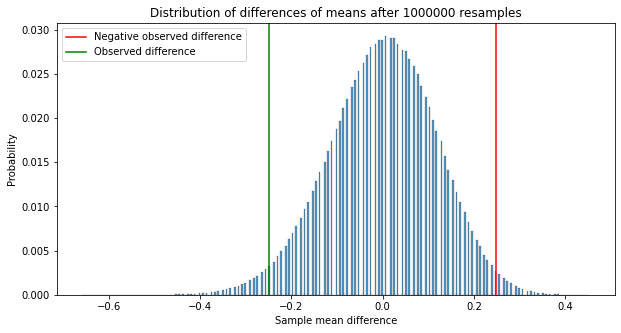

In [32]:
sns.histplot(data=dist, stat = 'probability', bins=300)
plt.axvline(x = data.loc[~org, :]['star'].mean() - data.loc[org, :]['star'].mean() , color = 'red', label='Negative observed difference')
plt.axvline(x = -data.loc[~org, :]['star'].mean() + data.loc[org, :]['star'].mean(), color = 'green', label='Observed difference')
plt.title('Distribution of differences of means after 1000000 resamples')
plt.xlabel('Sample mean difference')
plt.legend()
plt.show()

If we repeat the Monte Carlo simulation N times and for each of them we calculate the p-value, we can obtain a distribution of the p-values obtained. To plot the distribution of the p-values we use N=5000.

In [17]:
from tqdm import tqdm
n_iters = 5000
p_values = np.zeros(n_iters)  # Store the p values
for i in tqdm(np.arange(n_iters)):
    # Use fewer iterations than usual to save computation time.
    p = permutation(data.loc[org,'star'], data.loc[~org,'star'], niters=1000)[0]
    # Store the p value from the permutation test.
    p_values[i] = p

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:30<00:00,  8.77it/s]


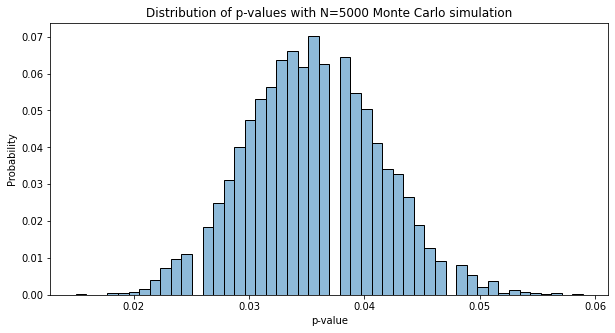

In [33]:
sns.histplot(data=p_values, stat = 'probability', alpha=0.5)
plt.title('Distribution of p-values with N=5000 Monte Carlo simulation')
plt.xlabel('p-value')
plt.show()

In [34]:
print(f'Out of the 5000 p-values calculated, only {np.sum(p_values>=0.05)} are above the 0.05 significance level')

Out of the 5000 p-values calculated, only 39 are above the 0.05 significance level
